In [1]:

!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
'''
  * transforms.ToTensor() will convert the numpy array (with a range of 0 to 255) to a float tensor (with the range of 0 to 1)

  * transforms.Normalize((0.5,), (0.5,)) specifies the mean and the deviation that would be used to normalize all channels of the tensor image
      Normalization does the following for each channel: image = (image - mean) / std.
      The value 0.5 was choose in this case cause the autor wanted to normalize the image in the range [-1,1].
      For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

      Normalization helps reducing the skewness and distortions.
'''
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

'''
  The DataLoader combine a dataset object along with different samplers (different strategies for providing data to algorithms) 
  and provides a batch (set of samples used in a interaction) of images.

  * gradient descent algorithms tend to get stuck in local minima, 
    so if you suffle your training data, you ensure that the subset changes with every single iterations.
'''
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0) # [1, 28, 28] to [28, 28, 1]
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # normalization
  image = image.clip(0, 1)
  return image

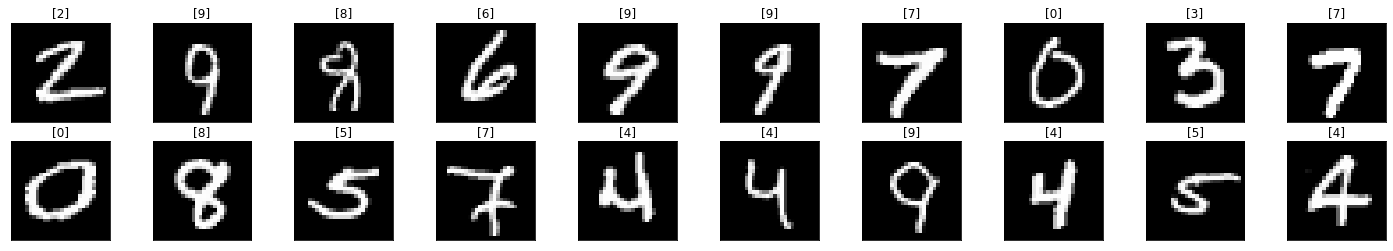

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [9]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9612, acc 77.6133 
validation loss: 0.4341, validation acc 88.2800 
epoch : 2
training loss: 0.3861, acc 89.1367 
validation loss: 0.3273, validation acc 90.7100 
epoch : 3
training loss: 0.3239, acc 90.6567 
validation loss: 0.2903, validation acc 91.4800 
epoch : 4
training loss: 0.2926, acc 91.4517 
validation loss: 0.2735, validation acc 92.3400 
epoch : 5
training loss: 0.2689, acc 92.2650 
validation loss: 0.2568, validation acc 92.7100 
epoch : 6
training loss: 0.2471, acc 92.9233 
validation loss: 0.2330, validation acc 93.3200 
epoch : 7
training loss: 0.2270, acc 93.4183 
validation loss: 0.2191, validation acc 93.5100 
epoch : 8
training loss: 0.2093, acc 93.9500 
validation loss: 0.2043, validation acc 94.2100 
epoch : 9
training loss: 0.1939, acc 94.3917 
validation loss: 0.1917, validation acc 94.5300 
epoch : 10
training loss: 0.1812, acc 94.7900 
validation loss: 0.1764, validation acc 94.9000 
epoch : 11
training loss: 0.1692, acc 95.1750 
va

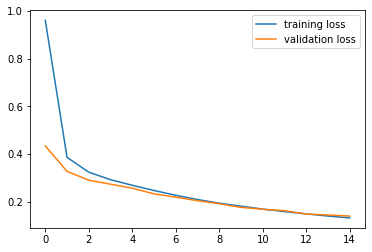

In [13]:
'''
  the training loss became less than validation loss, causing overfitting
  (Overfitting means that the neural network models the training data too well and fails when it faces new and yet unseen data)
  BUT for this case, it's ok.
'''
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

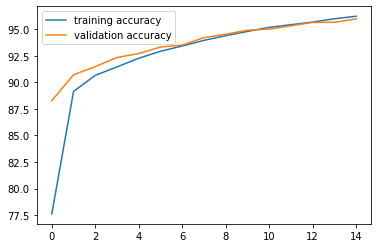

In [14]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

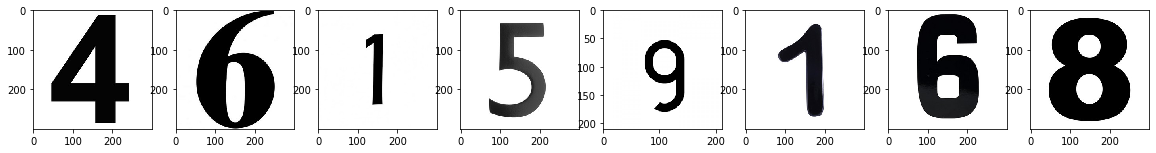

In [49]:
import PIL.ImageOps
import requests
from PIL import Image

urls = ['https://i.postimg.cc/C1ymcjh8/4.jpg', 'https://i.postimg.cc/brpLhp2N/4a0dbee4baf35aea8832838b2a8700c6.jpg',
        'https://i.postimg.cc/76gXdfhW/adesivo-de-numeracao-individual-05x09-numero-1-002801-01.jpg',
        'https://i.postimg.cc/qqwwBS8c/architectural-mailboxes-house-letters-numbers-3585b-5-64-1000.jpg',
        'https://i.postimg.cc/3rFnZ4Py/images.png', 'https://i.postimg.cc/wTxF4xpw/numero-1-preto-ceramica-esmaltada-numeros-residenciais.jpg',
        'https://i.postimg.cc/wTW2CKxg/pictures-of-number-6-43.jpg', 'https://i.postimg.cc/BnXpshtD/s-l1600.jpg']

columns = len(urls)
imgs = []

fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  response = requests.get(urls[idx], stream = True)
  img = Image.open(response.raw)
  fig.add_subplot(1, columns, idx+1)
  imgs.append(img)
  plt.imshow(img)

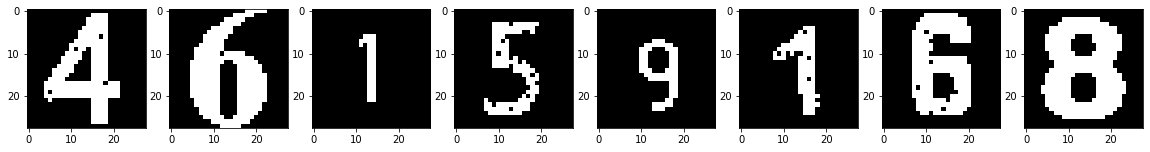

In [50]:
inverted_imgs = []
fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  img = PIL.ImageOps.invert(imgs[idx])
  img = img.convert('1')
  img = transform(img)
  inverted_imgs.append(img)
  fig.add_subplot(1, columns, idx+1)
  plt.imshow(im_convert(img))

In [56]:
for idx in range(0, columns):
  img = inverted_imgs[idx].view(inverted_imgs[idx].shape[0], -1)
  output = model(img)
  _, pred = torch.max(output, 1)
  print(pred.item(), end=" ")

2 0 1 5 9 3 5 3 

not got prediction huh

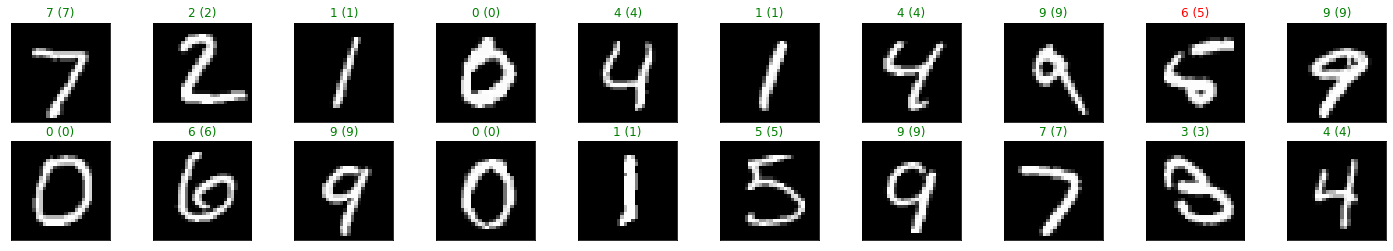

In [46]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))